In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import json
from collections import Counter
import numpy as np
import os
import shutil
import json
import random
from collections import defaultdict
import random

## Utils functions

In [2]:
def check_img_annot(path_img, path_txt):
    frame = cv2.imread(path_img).copy()
    box = []
    with open(path_txt, "r") as f:
        for i in f:
            box.append(i.split())
    #print("box : class, x, y, w, h \n", box)
    f.close()

    for boxx in box:
        
        cl,x,y,w,h = [eval(i) for i in boxx]

        h_frame,w_frame,channel = frame.shape

        # top left
        xtl = int(x*w_frame-w*w_frame/2)
        ytl = int(y*h_frame+h*h_frame/2)

        # bottom right
        xbr = int(x*w_frame+w*w_frame/2)
        ybr = int(y*h_frame-h*h_frame/2)

        frame = cv2.rectangle(frame, (xtl,ytl),(xbr,ybr),(0,255,0),2 )

    plt.imshow(frame)
    plt.show()

In [3]:
def coco_to_yolo(coco_bbox, image_width, image_height):
    x_min, y_min, width, height = coco_bbox
    
    # COCO format to YOLO format
    center_x = (x_min + width / 2) / image_width
    center_y = (y_min + height / 2) / image_height
    yolo_width = width / image_width
    yolo_height = height / image_height
    
    return [center_x, center_y, yolo_width, yolo_height]

def yolo_to_coco(yolo_bbox, image_width, image_height):
    center_x, center_y, yolo_width, yolo_height = yolo_bbox
    
    # YOLO format to COCO format
    x_min = int((center_x - yolo_width / 2) * image_width)
    y_min = int((center_y - yolo_height / 2) * image_height)
    width = int(yolo_width * image_width)
    height = int(yolo_height * image_height)
    
    return [x_min, y_min, width, height]

In [4]:
def get_data(video_path, annotation_path, data_save_path, per=1, 
             per_train=80, per_val=10):
    info = {}

    # IMAGES WITH ANNOTATION
    data = json.load(open(annotation_path))
    set_img = {i["image_id"] for i in data["annotations"]}

    # REDIMENTION OF IMG
    cap = cv2.VideoCapture(video_path)
    _,frame = cap.read()
    Ho,Wo,_=frame.shape
    r = frame.shape[0]/frame.shape[1] # H/W
    new_W = frame.shape[1]/per
    new_H = r*new_W
    dim = (int(new_W), int(new_H))
    
    
    try:
        os.mkdir(os.path.join(data_save_path,"images"))
    except:
        print("directory 'images' was created")
        print("all new file will be add")
        print()
    
    # SAVE IMAGES WITH ANNOTATIONS IN "images"
    count = 1
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    name_video = video_path.split("/")[-1].split(".")[0]
    
    while success:
        name = os.path.join(data_save_path,"images",
                            name_video+"_frame_"+str(count)+".png")
        if count in set_img:
            resized = cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)
            cv2.imwrite(name,resized)  # SAVE IMG
        success, frame = cap.read()
        count = count + 1
    cap.release()
    
    # SAVE ANNOTATION .TXT IN "labels"
    try:
        os.mkdir(os.path.join(data_save_path, "labels"))
    except:
        print("directory 'labels' was created")
        print("all news files will be add")
            
    for i in data["annotations"]:
        f = open(os.path.join(data_save_path,"labels",
                              name_video+"_frame_"+str(i["image_id"])+".txt"),"a")
        f.write(str(int(i["category_id"]-1))+ " ")
    
        # cl,x,y,w,h = [eval(i) for i in boxx] YOLO
        # # Bboxes are in [top-left-x, top-left-y, width, height]  COCO
        box = coco_to_yolo(i["bbox"], new_W, new_H)

        # due of resized
        box[0] = box[0]*new_W/Wo
        box[1] = box[1]*new_H/Ho
        box[2] = box[2]*new_W/Wo
        box[3] = box[3]*new_H/Ho
        
        for b in box:
            f.write( f"{b:.5f}" + " ")
        f.write("\n")
        f.close()
    
    # CREATE VAL, TEST, TRAIN
    '''
    labels = os.listdir(os.path.join(data_save_path,"labels"))
    train_labels = labels[0:int((len(labels) * per_train)/100)]
    val_labels = labels[int((len(labels) * per_train)/100):int((len(labels) * (per_train+per_val))/100)]
    test_labels = labels[int(len(labels) * (per_val+per_train)/100):]
    
    print("Directories to train")
    print("total : ", len(labels))
    print("train : ", len(train_labels))
    print("test  : ", len(test_labels))
    print("val   : ", len(val_labels))

    # copy images to train, val and test folders
    try:
        os.mkdir(os.path.join(data_save_path,"Train"))
    except:
        print("directory 'Train' was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Train","images"))
    except:
        print("directory 'Train/images' was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Train","labels"))
    except:
        print("directory was created")
        print("all new file will be add")

    for label in train_labels:
        filename = label.split(".")[0]
        #path = os.getcwd()
        # images source and destination path
        img_src = data_save_path+"/images/"+filename+'.png'
        img_dst = data_save_path+'/Train/images/'+filename+'.png'
        # labels source and destination path
        label_src = data_save_path+'/labels/'+filename+'.txt'
        label_dst = data_save_path+'/Train/labels/'+filename+'.txt'
        
        shutil.copy(img_src, img_dst)
        shutil.copy(label_src, label_dst)

    try:
        os.mkdir(os.path.join(data_save_path,"Val"))
    except:
        print("directory 'Val' was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Val","images"))
    except:
        print("directory 'Val/images' created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Val","labels"))
    except:
        print("directory was created")
        print("all new file will be add")


    for label in val_labels:
        filename = label.split(".")[0]
        #path = os.getcwd()
        # images source and destination path
        img_src = data_save_path+'/images/'+filename+'.png'
        img_dst = data_save_path+'/Val/images/'+filename+'.png'
        # labels source and destination path
        label_src = data_save_path+'/labels/'+filename+'.txt'
        label_dst = data_save_path+'/Val/labels/'+filename+'.txt'
        
        shutil.copy(img_src, img_dst)
        shutil.copy(label_src, label_dst)

    try:
        os.mkdir(os.path.join(data_save_path,"Test"))
    except:
        print("directory was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Test","images"))
    except:
        print("directory was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Test","labels"))
    except:
        print("directory was created")
        print("all new file will be add")


    for label in test_labels:
        filename = label.split(".")[0]
        #path = os.getcwd()
        # images source and destination path
        img_src = data_save_path+'/images/'+filename+'.png'
        img_dst = data_save_path+'/Test/images/'+filename+'.png'
        # labels source and destination path
        label_src = data_save_path+'/labels/'+filename+'.txt'
        label_dst = data_save_path+'/Test/labels/'+filename+'.txt'
        
        shutil.copy(img_src, img_dst)
        shutil.copy(label_src, label_dst)
'''

    info["categories"] = data["categories"]
    return info


# Get Raster Data

In [38]:
data = json.load(open('../data/video1.json'))

In [15]:
info = get_data(video_path="../data/video1.mp4", 
         annotation_path="../data/video1.json",
         data_save_path="../data/raster", per=1)

directory 'images' was created
all new file will be add

directory 'labels' was created
all news files will be add


In [39]:
categories = [{'id': 1, 'name': '1_Auto Privado', 'supercategory': ''},
              {'id': 2, 'name': '13_Bus', 'supercategory': ''},
              {'id': 3, 'name': '11_Camioneta rural', 'supercategory': ''},
              {'id': 4, 'name': '12_Microbus', 'supercategory': ''},
              {'id': 5, 'name': '4_Mototaxi', 'supercategory': ''},
              {'id': 6, 'name': '5_Moto lineal', 'supercategory': ''},
              {'id': 7, 'name': '9_Omnibus Interprovincial', 'supercategory': ''},
              {'id': 8, 'name': '10_Auto colectivo', 'supercategory': ''},
              {'id': 9, 'name': '14_Articulado', 'supercategory': ''},
              {'id': 10, 'name': '2_Cam. PickUp', 'supercategory': ''},
              {'id': 11, 'name': '3_Taxi', 'supercategory': ''},
              {'id': 12, 'name': '6_Bicicletas', 'supercategory': ''},
              {'id': 13, 'name': '7_Scooter', 'supercategory': ''},
              {'id': 14, 'name': '8_TransportenEscolar Personal', 'supercategory': ''},
              {'id': 15, 'name': '15_TC_Ligeros', 'supercategory': ''},
              {'id': 16, 'name': '16_TC Pesados', 'supercategory': ''},
              {'id': 17, 'name': '17_TC SemiTrailler Trailer', 'supercategory': ''},
              {'id': 18, 'name': '18_Triciclo', 'supercategory': ''},
              {'id': 19, 'name': '19_Ambulancia', 'supercategory': ''}]

# Train-Test dataset

In [40]:
test_size = 0.2
val_percent = 0.2

In [42]:
txt_dir = '../data/dataset/labels'

#image_to_classes
class_to_images = defaultdict(list)
image_to_classes = {}
for txt_file in os.listdir(txt_dir):
        if txt_file.endswith('.txt'):
            image_name = txt_file.replace('.txt', '.png')  # Assuming images are in .jpg format
            with open(os.path.join(txt_dir, txt_file), 'r') as file:
                classes_in_image = set()
                for line in file:
                    class_label = line.split()[0]  # Assuming class label is the first entry in each row
                    class_to_images[class_label].append(image_name)
                    classes_in_image.add(class_label)
                image_to_classes[image_name] = list(classes_in_image)

# Step 1: Count the occurrences of each class across all images
class_counts = Counter()
for classes in image_to_classes.values():
    class_counts.update(classes)
# Step 2: Define a proportional split (e.g., 80% train, 20% test)
train_set = {}
test_set = {}
current_test_counts = Counter()
# Step 3: Split the data while maintaining proportionality
for image, classes in image_to_classes.items():
    if all(current_test_counts[cls] / class_counts[cls] <= test_size for cls in classes):
        test_set[image] = classes
        current_test_counts.update(classes)
    else:
        train_set[image] = classes


# Print the result
print(f"Train set: {len(train_set)} images")
print(f"Test set: {len(test_set)} images")

Train set: 1211 images
Test set: 314 images


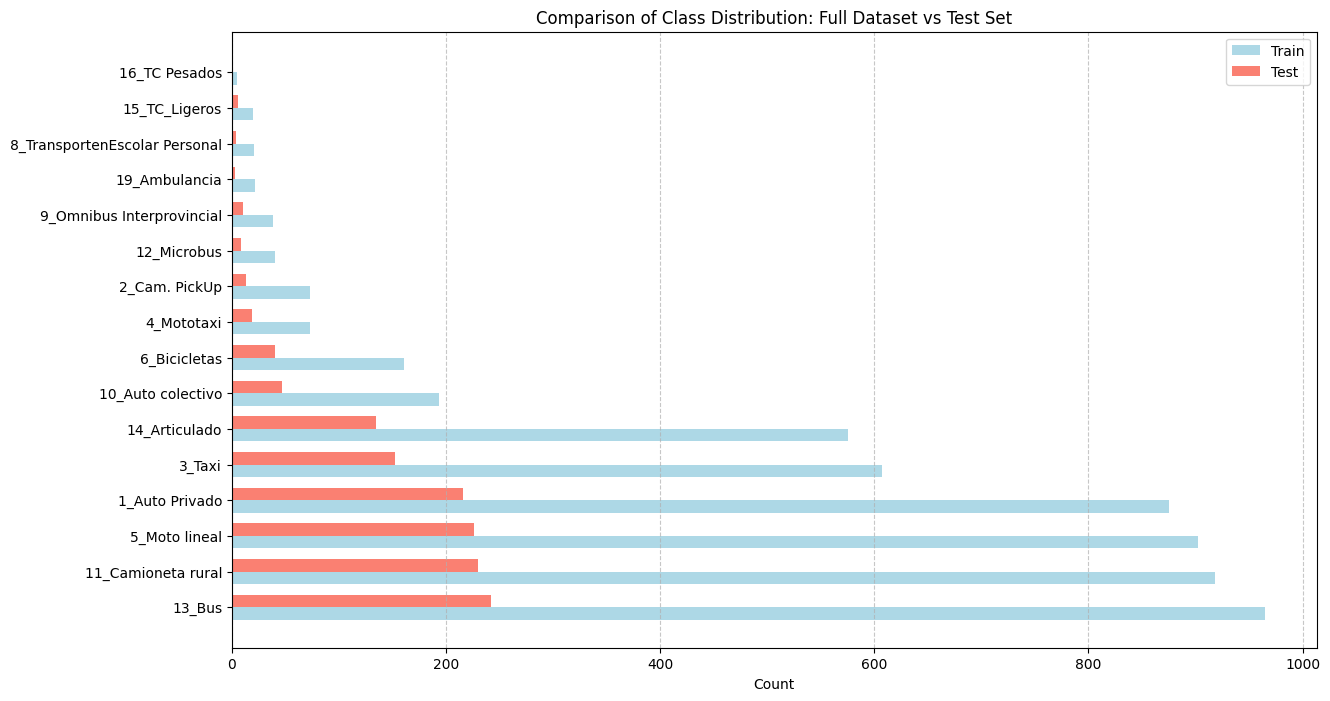

In [10]:
# Optional: Verify class distribution in the test set
test_class_distribution = Counter()
for classes in test_set.values():
    test_class_distribution.update(classes)

    # Optional: Verify class distribution in the test set
train_class_distribution = Counter()
for classes in train_set.values():
    train_class_distribution.update(classes)

# # Create a mapping from ID to name
id_to_name = {str(category['id'] - 1): category['name'] for category in categories}

# Replace numeric keys with category names
mapped_test_distribution = {id_to_name[k]: v for k, v in test_class_distribution.items() if k in id_to_name}

# Sort the mapped data by values in descending order
sorted_mapped_test_distribution = dict(sorted(mapped_test_distribution.items(), key=lambda item: item[1], reverse=True))

# Replace numeric keys with category names
mapped_train_distribution = {id_to_name[k]: v for k, v in train_class_distribution.items() if k in id_to_name}

# Sort the mapped data by values in descending order
sorted_mapped_train_distribution = dict(sorted(mapped_train_distribution.items(), key=lambda item: item[1], reverse=True))

# Ensure both dictionaries have the same keys in the same order
categories = list(sorted_mapped_train_distribution.keys())

test_values = [sorted_mapped_test_distribution.get(cat, 0) for cat in categories]
full_values = [sorted_mapped_train_distribution[cat] for cat in categories]

# Set up the plot
x = np.arange(len(categories))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))

bars1 = ax.barh(x - width/2, full_values, width, label='Train', color='lightblue')
bars2 = ax.barh(x + width/2, test_values, width, label='Test', color='salmon')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Count')
ax.set_title('Comparison of Class Distribution: Full Dataset vs Test Set')
ax.set_yticks(x)
ax.set_yticklabels(categories)
ax.legend()

# Add a grid for easier reading
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.savefig('../data/train_test.png')
plt.show()

In [43]:
train_set = list(train_set.keys())
test_set = list(test_set.keys())

In [46]:
['../data/dataset/images/'+i for i in test_set]

['../data/dataset/images/video1_frame_29546.png',
 '../data/dataset/images/video1_frame_29246.png',
 '../data/dataset/images/video1_frame_3741.png',
 '../data/dataset/images/video1_frame_25486.png',
 '../data/dataset/images/video1_frame_27566.png',
 '../data/dataset/images/video1_frame_2421.png',
 '../data/dataset/images/video1_frame_12371.png',
 '../data/dataset/images/video1_frame_27206.png',
 '../data/dataset/images/video1_frame_6756.png',
 '../data/dataset/images/video1_frame_11011.png',
 '../data/dataset/images/video1_frame_12571.png',
 '../data/dataset/images/video1_frame_28466.png',
 '../data/dataset/images/video1_frame_16366.png',
 '../data/dataset/images/video1_frame_6156.png',
 '../data/dataset/images/video1_frame_4361.png',
 '../data/dataset/images/video1_frame_5596.png',
 '../data/dataset/images/video1_frame_6616.png',
 '../data/dataset/images/video1_frame_8016.png',
 '../data/dataset/images/video1_frame_13871.png',
 '../data/dataset/images/video1_frame_6136.png',
 '../data

In [47]:
test_set = ['../data/dataset/images/'+i for i in test_set]
train_set = ['../data/dataset/images/'+i for i in train_set]

In [49]:
# Specify the filename
filename = '../data/dataset/test.txt'

# Open the file in write mode
with open(filename, 'w') as file:
    # Write each item to the file, followed by a newline
    for item in test_set:
        file.write(f"{item}\n")

In [50]:
# Calculate the number of items to select (20% of the list)
num_to_select = int(len(train_set) * val_percent)

# Select 20% of the items randomly
val_set = random.sample(train_set, num_to_select)

# Remove the selected items from the original list
for item in val_set:
    train_set.remove(item)

In [51]:
with open('../data/dataset/train.txt', 'w') as file :
    for item in train_set:
        file.write(f'{item}\n')
with open('../data/dataset/val.txt', 'w') as file :
    for item in val_set:
        file.write(f'{item}\n')

In [52]:
len(train_set)

969

In [104]:
len(val_set)

193

In [105]:
len(test_set)

314

# Train model

In [19]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolo11n.yaml")  # build a new model from YAML
model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)
#model = YOLO("yolo11n.yaml").load("yolo11n.pt")  # build from YAML and transfer weights


In [2]:
with open('yolo11n.txt', 'w') as f:
    f.write(str(model.model))

In [57]:
# Train the model
results = model.train(data="data.yaml", 
                      epochs=100,
                      batch=16,
                      freeze=5,
                      verbose=True,
                      save_period=10,
                      save=True,
                      pretrained='./runs/detect/yolo11n_models3/weights/best.pt',
                      name='yolo11n_models',
                      plots=True,
                      )

New https://pypi.org/project/ultralytics/8.3.24 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.21 🚀 Python-3.10.12 torch-2.5.0+cu124 CPU (AMD Ryzen 3 3200G with Radeon Vega Graphics)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=None, workers=8, project=None, name=yolo11n_models4, exist_ok=False, pretrained=./runs/detect/yolo11n_models3/weights/best.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=5, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, re

train: Scanning ../data/dataset/labels... 969 images, 0 backgrounds, 0 corrupt: 100%|██████████| 969/969 [00:08<00:00, 113.44it/s]

train: New cache created: ../data/dataset/labels.cache



val: Scanning ../data/dataset/labels... 242 images, 0 backgrounds, 0 corrupt: 100%|██████████| 242/242 [00:01<00:00, 157.51it/s]

val: WARNING ⚠️ ../data/dataset/images/video1_frame_9876.png: 1 duplicate labels removed
val: New cache created: ../data/dataset/labels.cache


Plotting labels to runs/detect/yolo11n_models4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000435, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolo11n_models4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.337      3.055      1.074        210        640:   3%|▎         | 2/61 [00:16<08:12,  8.34s/it]


KeyboardInterrupt: 


0: 384x640 1 bicycle, 106.9ms
Speed: 2.9ms preprocess, 106.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


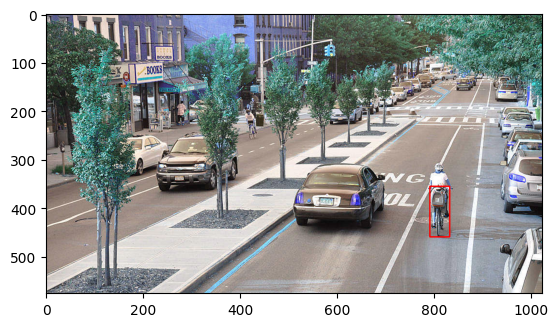

In [34]:
model = YOLO("yolo11n.pt")
image = cv.imread('../data/demo.jpg')
results = model(image, classes=[1])
for x,y,w,h in results[0].boxes.xywh:
    x, y, w, h = int(x.item()), int(y.item()), int(w.item()), int(h.item())
    dummy = cv.rectangle(image, (int(x-w/2), int(y-h/2)), (int(x + w/2), int(y + h/2)), (255, 0, 0), 2) 
plt.imshow(dummy)

In [47]:
my_dict = model.names

values_to_find = ['banana', 'orange']

# Create a dictionary to store the result
keys_for_values = {value: [] for value in values_to_find}

# Loop through the dictionary and find keys for each value
for key, value in my_dict.items():
    if value in values_to_find:
        keys_for_values[value] = key

print(keys_for_values)


{'banana': 46, 'orange': 49}


In [6]:
for x,y,w,h in results[0].boxes.xywh:
    x, y, w, h = int(x.item()), int(y.item()), int(w.item()), int(h.item())
    print(x, y, w, h)

606 376 193 131
981 350 84 125
290 310 125 112
980 505 86 137
208 291 92 81
972 221 76 56
813 365 53 112
952 163 46 36
982 277 82 77
863 148 33 21
604 212 38 31
784 136 39 32
712 180 25 24
813 408 41 104
865 142 37 27
728 166 34 29


In [13]:
result = model(image,classes=[1], show_boxes=True)


0: 384x640 (no detections), 185.1ms
Speed: 4.5ms preprocess, 185.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


array([[[116, 125, 135],
        [124, 133, 143],
        [123, 131, 144],
        ...,
        [ 34,  79,  53],
        [ 94, 150, 127],
        [ 47, 111,  89]],

       [[115, 123, 136],
        [117, 125, 138],
        [116, 123, 138],
        ...,
        [ 21,  63,  40],
        [ 58, 112,  89],
        [ 79, 141, 119]],

       [[124, 128, 146],
        [121, 125, 143],
        [123, 127, 146],
        ...,
        [ 97, 136, 114],
        [  0,  47,  27],
        [ 91, 146, 129]],

       ...,

       [[ 98,  98,  98],
        [113, 115, 116],
        [122, 124, 125],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[169, 166, 162],
        [176, 174, 173],
        [169, 167, 166],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[215, 211, 206],
        [160, 156, 151],
        [100,  97,  93],
        ...,
        [143, 130, 114],
        [142, 129, 113],
        [142, 129, 113]]

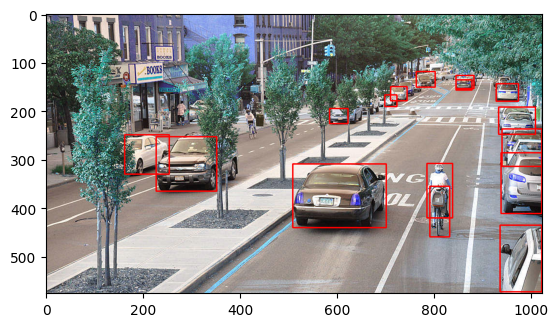

In [31]:
plt.imshow(results[0].orig_img)